# How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference



### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 15543, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 15543 (delta 60), reused 94 (delta 45), pack-reused 15393
Receiving objects: 100% (15543/15543), 14.59 MiB | 19.01 MiB/s, done.


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.3 MB/s eta 0:00:00
Setup complete. Using torch 2.0.0+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


# Download Correctly Formatted Custom Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).



![YOLOv5 PyTorch export](https://i.imgur.com/5vr9G2u.png)


In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="BrNUqD8TsBHLUOV9OLz7")
project = rf.workspace("bin-detection").project("assembly-llgww")
dataset = project.version(6).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Assembly--6 in yolov5pytorch:: 100%|██████████| 3364/3364 [00:01<00:00, 1864.07it/s]


In [ ]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in
#from roboflow import Roboflow
#rf = Roboflow(api_key="YOUR API KEY HERE")
#project = rf.workspace().project("YOUR PROJECT")
#dataset = project.version("YOUR VERSION").download("yolov5")

/content/yolov5


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- Base-pallet
- Corner_damage
- Edge_damage
- Logo_repair
- Plain
- sides-metal
nc: 6
roboflow:
  license: MIT
  project: assembly-llgww
  url: https://universe.roboflow.com/bin-detection/assembly-llgww/dataset/6
  version: 6
  workspace: bin-detection
test: ../test/images
train: Assembly--6/train/images
val: Assembly--6/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 500 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache --save-period 1

/content/yolov5
2023-04-20 02:59:23.644184: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 02:59:24.478200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/Assembly--6/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=500, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
!kill1752
%reload_ext tensorboard
%tensorboard --logdir runs

/bin/bash: kill1752: command not found


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-04-20 05:56:54.613395: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 05:56:56.118229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-20 05:56:59.378834: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 05:56:59.676061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had n

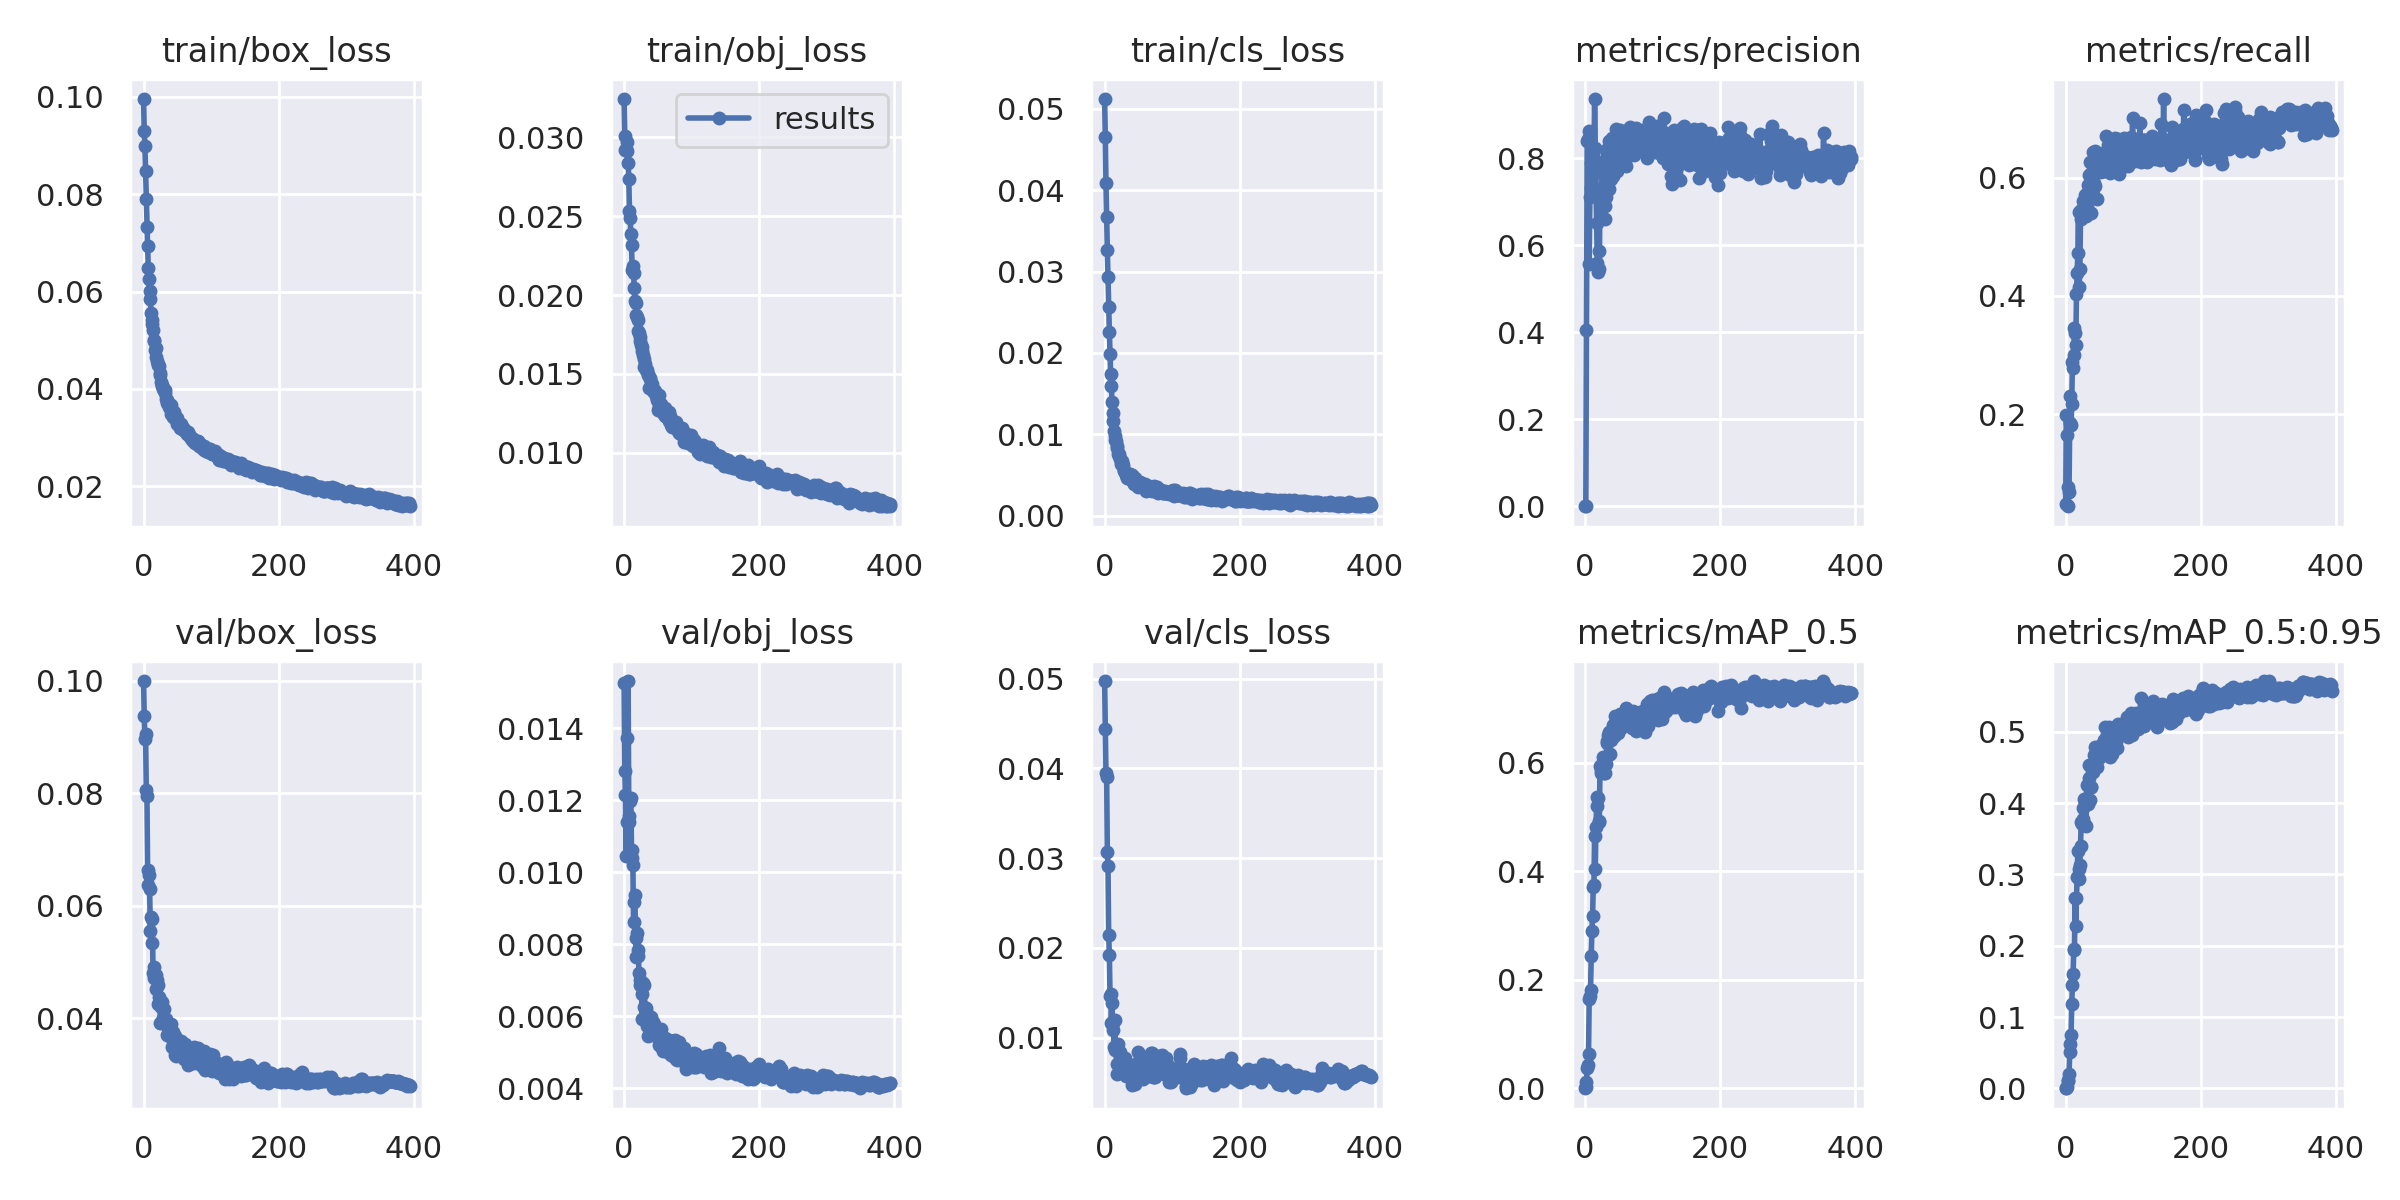

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH TRAINING DATA:


FileNotFoundError: ignored

In [ ]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


FileNotFoundError: ignored

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [ ]:
%ls runs/train/yolov5s_results/weights

best.pt      epoch15.pt   epoch21.pt   epoch280.pt  epoch340.pt  epoch45.pt
epoch0.pt    epoch160.pt  epoch220.pt  epoch281.pt  epoch341.pt  epoch46.pt
epoch100.pt  epoch161.pt  epoch221.pt  epoch282.pt  epoch342.pt  epoch47.pt
epoch101.pt  epoch162.pt  epoch222.pt  epoch283.pt  epoch343.pt  epoch48.pt
epoch102.pt  epoch163.pt  epoch223.pt  epoch284.pt  epoch344.pt  epoch49.pt
epoch103.pt  epoch164.pt  epoch224.pt  epoch285.pt  epoch345.pt  epoch4.pt
epoch104.pt  epoch165.pt  epoch225.pt  epoch286.pt  epoch346.pt  epoch50.pt
epoch105.pt  epoch166.pt  epoch226.pt  epoch287.pt  epoch347.pt  epoch51.pt
epoch106.pt  epoch167.pt  epoch227.pt  epoch288.pt  epoch348.pt  epoch52.pt
epoch107.pt  epoch168.pt  epoch228.pt  epoch289.pt  epoch349.pt  epoch53.pt
epoch108.pt  epoch169.pt  epoch229.pt  epoch28.pt   epoch34.pt   epoch54.pt
epoch109.pt  epoch16.pt   epoch22.pt   epoch290.pt  epoch350.pt  epoch55.pt
epoch10.pt   epoch170.pt  epoch230.pt  epoch291.pt  epoch351.pt  epoch56.pt
epoch110.pt  

In [ ]:

!python detect.py --weights best.pt --img 640 --conf 0.4 --source video1.mp4

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!-
%cd /content/yolov5
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.4 --source /content/video1.mp4

Streaming output truncated to the last 5000 lines.
video 1/1 (3923/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.8ms
video 1/1 (3924/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3925/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3926/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 8.2ms
video 1/1 (3927/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3928/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3929/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.8ms
video 1/1 (3930/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3931/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3932/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.8ms
video 1/1 (3933/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3934/8920) /content/video1.mp4: 384x640 1 sides-nonmetal, 7.7ms
video 1/1 (3935/8920) /content/video1.mp4: 384x64

In [ ]:
%cd /content/yolov5
!python val.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.4 --data {dataset.location}/data.yaml --task val

/content/yolov5
val: data=/content/yolov5/Assembly--6/data.yaml, weights=['runs/train/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.4, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.4 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7260003 parameters, 0 gradients
val: Scanning /content/yolov5/Assembly--6/valid/labels.cache... 105 images, 1 backgrounds, 0 corrupt: 100% 105/105 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:06<00:00,  1.56s/it]
                   all        105        156      0.805      0.682      0.763      0.605
         

In [ ]:
%cd /content/yolov5
!python val.py --weights runs/train/yolov5s_results/weights/best.pt --img 640 --conf 0.4 --data {dataset.location}/data.yaml --task test

/content/yolov5
val: data=/content/yolov5/Assembly--6/data.yaml, weights=['runs/train/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.4, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.4 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7260003 parameters, 0 gradients
test: Scanning /content/yolov5/test/labels... 105 images, 0 backgrounds, 0 corrupt: 100% 105/105 [00:00<00:00, 445.04it/s]
test: New cache created: /content/yolov5/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 4/4 [00:04<00:00,  1.16s/it]
                   all        105        141   

In [ ]:
%cd /content/yolov5
!python detect.py --data {dataset.location}/data.yaml --weights runs/train/yolov5s_results/weights/best.pt --img 640

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=data/images, data=/content/yolov5/Assembly--6/data.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 2 sides-metals, 41.7ms
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 1 Plain, 41.4ms
Speed: 0.5ms pre-process, 41.6ms inference, 53.8ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.mp4'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

ValueError: ignored

# Deploy Model Weights to Roboflow

Now that you have trained your custom detector, you can upload it to Roboflow to deploy you model to a Hosted API and edge containers.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov5", model_path=f"/content/yolov5/runs/train/yolov5s_results/")

View the status of your deployment at: https://app.roboflow.com/bin-detection/assembly-llgww/deploy/4
Share your model with the world at: https://universe.roboflow.com/bin-detection/assembly-llgww/model/4


In [ ]:
#While your deployment is processing, checkout the deployment docs to take your model to most destinations https://docs.roboflow.com/inference

In [ ]:
#Run inference on your model on a persistant, auto-scaling, cloud API
%cd /content/yolov5
#load model
model = project.version(dataset.version).model

#choose random test set image
import os, random
test_set_loc = "/content/yolov5/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image, confidence=40, overlap=30).json()
pred

/content/yolov5
running inference on frame202_png.rf.603c12e3be47a29a92b99a8a42812914.jpg


{'predictions': [{'x': 288.0,
   'y': 263.0,
   'width': 278.0,
   'height': 526.0,
   'confidence': 0.8988080620765686,
   'class': 'sides-metal',
   'image_path': '/content/yolov5/test/images/frame202_png.rf.603c12e3be47a29a92b99a8a42812914.jpg',
   'prediction_type': 'ObjectDetectionModel'}],
 'image': {'width': '640', 'height': '640'}}

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
     

Mounted at /content/gdrive


In [ ]:

%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/gdrive/MyDrive/CSE120

In [ ]:
%cd /content
model = torch.hub.load('/content/yolov5', 'custom', path='/content/yolov5/runs/train/yolov5s_results/weights/best.pt',source='local',force_reload=True,device= 'cpu' )

/content
[Errno 2] No such file or directory: '/usr/local/lib/python3.9/dist-packages/pyparsing-3.0.9.dist-info/METADATA'


YOLOv5 🚀 v7.0-72-g064365d Python-3.9.16 torch-2.0.0+cu118 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7260003 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
%cd /content

result = model('/content/video1.mp4')

/content


UnidentifiedImageError: ignored